## K nearest neighbors

<p>Le principe initial du knn est qu'il identifie les k échantillons les plus proches d'une nouvelle donnée grâce à l'espace de caractéristiques, puis attribue une étiquette basée sur un vote majoritaire ou une moyenne.<br>
Dans notre cas le travail avec des images nécessite de créer une forme qui permettra à notre algorithme de travailler avec.<p>
Pour procéder à cette identification, nous avons decidé d'appliquer certains paramètres :

* Redimensionnement : Les images sont redimensionnées pour avoir des dimensions uniformes.
* Flatten : Les images, qui sont initialement en format matriciel, sont transformées en vecteurs de caractéristiques unidimensionnels.
* Normalisation : Les valeurs des pixels sont souvent normalisées pour faciliter les calculs et améliorer les performances de l'algorithme.
* Le cropping/découpe : Découper l'image en question pour n'avoir que la partie qui nous intéresse.

### Loading the pictures
Avant toute chose, il y a eu une mise en place un wrapper timing_function qui permettra d'éstimer le temps d'éstimer le temps nécessaire pour chaque fonction.
Pour ce faire, nous allons procéder à un chargement des images à partir de nos dossiers.


In [1]:
import os
from PIL import Image
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
import csv
import cv2
import pandas as pd

import time
import matplotlib.pyplot as plt

#directories
train_normal_dir = 'train/NORMAL'
test_normal_dir = 'test/NORMAL'
train_pneumonia_dir = 'train/PNEUMONIA'
test_pneumonia_dir = 'test/PNEUMONIA'


def timing_function(func):
    """Gives the time taken to execute a function.
    :param func: Function to be executed on."""

    def wrapper(*args, **kwargs):
        start = time.time()
        result = func(*args, **kwargs)
        end = time.time()
        print(f"{func.__name__} took {end - start:.2f} seconds")
        return result

    return wrapper


def crop_lungs_from_image(img):
    """Crops only lungs image from image.
    :param img: image to be cropped.
    :returns: cropped image."""
    img_cv = np.array(img)
    _, thresh = cv2.threshold(img_cv, 15, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)
    cropped_img_cv = img_cv[y:y + h, x:x + w]
    cropped_img = Image.fromarray(cropped_img_cv)
    return cropped_img


@timing_function
def load_images_from_folder(folder, label, size):
    """Loads images from folder.
    :param folder : containing images to be loaded.
    :param label: label of images to be loaded.
    :param size: size of images to be loaded.
    :returns: images: loaded images
    :returns: labels: loaded labels."""
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        with Image.open(img_path) as img:
            # Greyish colors = L, Normal colors = P
            img = img.convert('L')
            # Cropping
            img = crop_lungs_from_image(img)
            # Resizing
            img = img.resize((size, size))
            img_array = np.array(img)
            # Normalization
            scaler = MinMaxScaler(feature_range=(0, 1))
            img_array = scaler.fit_transform(img_array.reshape(-1, 1))
            images.append(img_array.flatten())
            labels.append(label)

    return images, labels


def process_new_image(image_path):
    """Processes new image.
    :param image_path: path to image to be processed.
    :returns: processed image."""
    size = 68
    with Image.open(image_path) as img:
        img = img.convert('L')
        img = crop_lungs_from_image(img)
        img = img.resize((size, size))
        img_array = np.array(img)
        scaler = MinMaxScaler(feature_range=(0, 1))
        img_array = scaler.fit_transform(img_array.reshape(-1, 1))
        img_array = img_array.flatten()
        return img_array.flatten()


# train
print("Loading images for normal data")
start_time = time.time()
normal_images, normal_labels = load_images_from_folder(train_normal_dir, 0, 68)
print("Loading images for pneumonia data")
pneumonia_images, pneumonia_labels = load_images_from_folder(train_pneumonia_dir, 1, 68)
x_train = normal_images + pneumonia_images
y_train = normal_labels + pneumonia_labels
load_train_time = time.time() - start_time

# testing
start_time = time.time()
print("Loading images for normal data")
normal_test_images, normal_test_labels = load_images_from_folder(test_normal_dir, 0, 68)
print("Loading images for pneumonia data")
pneumonia_test_images, pneumonia_test_labels = load_images_from_folder(test_pneumonia_dir, 1, 68)
x_test = normal_test_images + pneumonia_test_images
y_test = normal_test_labels + pneumonia_test_labels
load_test_time = time.time() - start_time

Loading images for normal data
load_images_from_folder took 17.27 seconds
Loading images for pneumonia data
load_images_from_folder took 13.00 seconds
Loading images for normal data
load_images_from_folder took 2.77 seconds
Loading images for pneumonia data
load_images_from_folder took 1.13 seconds


<p> De cette manière, nous avons mis en place le processus de chargement de l'image que nous voulions. <br>
 Au cours des tests, nous avons remarqué que les jeux de données n'étaient pas équilibrés et que cela faussait les résultats. Il y avait beaucoup trop de jeu d'entrainement et pas assez de données de test. J'ai donc décidé de séparer le tout en 70 % de tests, 15% de validation et 15% de tests. De plus j'ai essayé d'équilibrer les jeux pour qu'on puisse avoir des proportions similaires. <p>
(Je n'étais pas sûr si nous devions intégrer un jeu de validation pour les hyper-paramètres, mais je l'ai tout de même fait vu que c'était demandé dans le sujet, si c'est faux je vous demanderais de pas en tenir rigueur)

In [2]:
from k_nearest_neighbors import report_data_distribution


def load_and_split_data(train_normal_path, train_pneumonia_path, virus_bacteria='false'):
    """
    :param train_normal_path: path to normal images folder.
    :param train_pneumonia_path: path to pneumonia images folder.
    :return: x_train, x_test, y_train, y_test.
    """
    size = 68
    print("Loading images for train normal data")
    normal_images, normal_labels = load_images_from_folder(train_normal_path, 0, size)
    if virus_bacteria != 'false':
        print("Loading bacteria images for train pneumonia data")
        pneumonia_bacteria_images, pneumonia_bacteria_labels = load_images_from_folder(train_pneumonia_path, 1, size)

    else:
        print("Loading images for train pneumonia data")
        pneumonia_images, pneumonia_labels = load_images_from_folder(train_pneumonia_path, 1, size)
    x = normal_images + pneumonia_images
    print(f"Training data: {len(x)} samples")

    y = normal_labels + pneumonia_labels
    # splitting the number of train images
    x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.2,
                                                        random_state=42)
    # adding the splitted images into the validation and test set
    x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5,
                                                    random_state=42)
    print("Loading images for test normal data")
    normal_test_images, normal_test_labels = load_images_from_folder(test_normal_dir, 0, size)
    print("Loading images for test pneumonia data")
    pneumonia_test_images, pneumonia_test_labels = load_images_from_folder(test_pneumonia_dir, 1, size)
    print(
        f"Testing data: We have {len(pneumonia_test_images)} pneumonia samples, {len(normal_test_images)}"
        f" normal samples, for a total of {len(x_test)} samples")
    x_test = x_test + normal_test_images + pneumonia_test_images
    print(f"Testing data: {len(x_test)} samples")
    y_test = y_test + normal_test_labels + pneumonia_test_labels
    report_data_distribution(x_train, x_val, x_test)
    return x_train, x_test, y_train, y_test, x_val, y_val,


Une fois finis, nous pouvons passer à l'étape suivante qui nous permettra de définir les hyperparamétres clés 
### Hyperparamètres
 * weights : 
    * uniform : Tous les voisins auront le même poids.
    * distance : Les voisins les plus proches auront un poids supérieur à ceux les plus éloignés.
 * n_neighbors: Le nombre de voisins que nous allons prendre en compte
* algorithm: Le type d'algorithmes que nous allons utiliser
   * ball_tree
    * kd_tree

La majorité des informations sont recensées directement sur la page Scikit learn [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
Pour trouver rapidement les hyperparametres nous allons passer par de la cross-validation. Cette méthode d'évaluation des performances des modèles permet de s'assurer de leur capacité à généraliser sur de nouvelles données. Elle consiste à diviser le jeu de données en plusieurs sous-ensembles ou "folds". Ensuite, le modèle est entraîné sur tous les sous-ensembles sauf un, utilisé pour la validation, et ce processus est répété de sorte que chaque sous-ensemble soit utilisé une fois comme données de validation. Les résultats de chaque itération sont combinés pour fournir une estimation globale de la performance du modèle. Cette technique est particulièrement utile pour réduire le risque de surajustement, assurant que le modèle performe bien non seulement sur les données d'entraînement mais aussi sur des données non vues auparavant.

### La cross validation
<p> On va chercher les meilleurs hyper-paramétres pour la méthode knn. Pour ce faire on va utiliser la validation croisée. Une fois les paramétres identifiés nous pourrons utiliser la meilleure combinaison et effectuer les tests.

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    n_splits c'est le nombre de tentatives differents pour chaque combinaison d'hyperparemtres
    shuffle permet la mélange du jeu de données
    
    grid_search = GridSearchCV(knn, param_grid, scoring='accuracy', cv=cv, verbose=3, n_jobs=-1)
    Knn not type de modéle 
    scoring nous permets de spécifier quel param on cherche un priorité
    verbose nous donne tous les détails, pratique pour voir l'avancée
    n_jobs détermine le nombre de jobs en paralléle. -1 étant le max qu'on puisse donner
    



load_images_from_folder took 17.55 seconds
load_images_from_folder took 13.75 seconds
About to start grid search
Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best parameters found:  {'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 15, 'weights': 'uniform'}
Test Accuracy: 0.95
              precision    recall  f1-score   support

      Normal       0.95      0.85      0.90       268
   Pneumonia       0.95      0.99      0.97       776

    accuracy                           0.95      1044
   macro avg       0.95      0.92      0.93      1044
weighted avg       0.95      0.95      0.95      1044



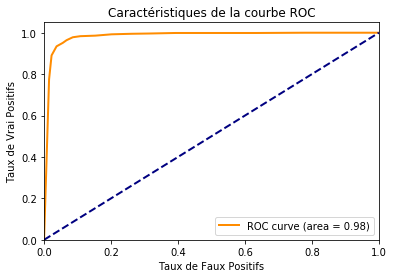

cross_validation took 2936.88 seconds


In [20]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

@timing_function
def cross_validation():
    size = 68
    normal_images, normal_labels = load_images_from_folder(train_normal_dir, 0, size)
    pneumonia_images, pneumonia_labels = load_images_from_folder(train_pneumonia_dir, 1, size)
    x = normal_images + pneumonia_images
    y = normal_labels + pneumonia_labels

    # Split into train+val and test initially
    x_train_val, x_test, y_train_val, y_test = train_test_split(x, y, test_size=0.20, stratify=y, random_state=42)
    param_grid = {'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17],
                  'weights': ['uniform', 'distance'],
                  'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                  'metric': ['euclidean', 'manhattan']}

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    knn = KNeighborsClassifier()
    print("About to start grid search")
    grid_search = GridSearchCV(knn, param_grid, scoring='accuracy', cv=cv, verbose=2, n_jobs=-1)
    grid_search.fit(x_train_val, y_train_val)
    print("Best parameters found: ", grid_search.best_params_)
    best_knn = grid_search.best_estimator_

    y_test_pred = best_knn.predict(x_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print(f"Test Accuracy: {test_accuracy:.2f}")
    report = classification_report(y_test, y_test_pred, target_names=['Normal', 'Pneumonia'])
    print(report)
    plot_roc_curve(best_knn, x_test, y_test)
    return best_knn


best_knn = cross_validation()

Ce qui va nous donner:
Best parameters found:  {'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 15, 'weights': 'uniform'}
Test Accuracy: 0.95
   
                 precision    recall  f1-score   support 

    Normal          0.95      0.85      0.90       268 
    Pneumonia       0.95      0.99      0.97       776 

    accuracy                            0.95      1044 
    macro avg       0.95      0.92      0.93      1044 
    weighted avg    0.95      0.95      0.95      1044 
    [Time per function]cross_validation took 2879.00 seconds 
Jupiter notebook n'est pas vraiment compatible avec jupyter notebook :https://github.com/scikit-learn/scikit-learn/issues/22849 

(Si besoin le fichier Metrics/cross_validation contient les logs de la crossvalidation quand elle a tourné sur ma machine)
<p>On pourra en conclure que l'on a plûtot une bonne précision avec le knn. Les résultats de votre validation croisée indiquent que le modèle KNN optimal, utilisant l'algorithme 'auto' avec la métrique de distance 'manhattan' et 15 voisins, a atteint une précision globale impressionnante de 95% sur le jeu de test. Pour les classes spécifiques, il montre une précision et un rappel élevés pour la classe 'Pneumonia', ce qui suggère une excellente capacité à identifier correctement ces cas.<br>
Maintenant que nous avons nos hyperparamètres, nous pouvons directement appeler le "best_knn" et l'utiliser pour le jeu de test. (Je ne le fais pas à cause du rapport, mais en dessous, il y aura l'algo non compilé disponible si besoin). Si on devait refaire le modéle avec les bons paramètres, il ressemblerait à cela : <p>


In [22]:
@timing_function
def train_model(x_train_value, y_train_value):
    print("Starting training model")
    model = KNeighborsClassifier(algorithm= 'auto', metric= 'manhattan', n_neighbors= 15, weights= 'uniform')
    model.fit(x_train_value, y_train_value)
    print("Finished training model")
    return model

knn = train_model(x_train, y_train)


Starting training model
Finished training model
train_model took 0.07 seconds


Par la suite nous allons faire ajouter des metrics pour voir si notre algorithme est bon: 
### La courbe de ROC
Elle représente graphiquement le taux de vrais positifs en fonction du taux de faux positifs. Plus l'aire sous la courbe tend vers 1 et plus elle est précise. 

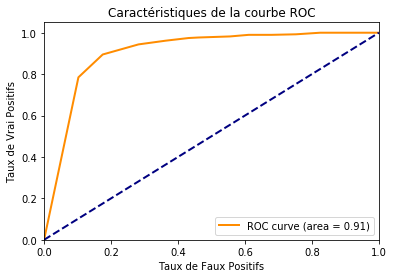

In [25]:
from sklearn.metrics import roc_curve, auc


def plot_roc_curve(model, x_test, y_test):
    y_probs = model.predict_proba(x_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taux de Faux Positifs')
    plt.ylabel('Taux de Vrai Positifs')
    plt.title('Caractéristiques de la courbe ROC')
    plt.legend(loc="lower right")
    plt.show()
 
 
plot_roc_curve(best_knn, x_test, y_test)


La courbe de roc nous montre que notre méthode est efficace et loin du hasard qui est représenté par la ligne bleue. La surface recouverte étant proche de 1 indique une très bonne efficacité aussi. <br>
Une fois la courbe de ROC dessinée, nous allons pouvoir passer à notre jeu de tests et utiliser notre modèle dessus en espérant avoir de bons résultats. <br>
On va afficher par la même occasion notre matrice de confusion pour voir les taux que l'on obtient. Il est important de ne pas avoir trop de faux-positifs et faux négatifs sinon cela signifie que l'on a un problème avec nos données. 

Starting test model
Test Accuracy: 0.77
Normalized confusion matrix


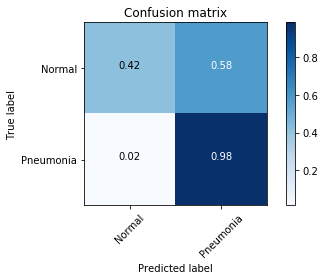

{'Normal': {'precision': 0.9423076923076923, 'recall': 0.4188034188034188, 'f1-score': 0.5798816568047337, 'support': 234}, 'Pneumonia': {'precision': 0.7384615384615385, 'recall': 0.9846153846153847, 'f1-score': 0.843956043956044, 'support': 390}, 'accuracy': 0.7724358974358975, 'macro avg': {'precision': 0.8403846153846154, 'recall': 0.7017094017094018, 'f1-score': 0.7119188503803888, 'support': 624}, 'weighted avg': {'precision': 0.8149038461538461, 'recall': 0.7724358974358975, 'f1-score': 0.7449281487743027, 'support': 624}}
Finished test model
0.772435897436 {'Normal': {'precision': 0.9423076923076923, 'recall': 0.4188034188034188, 'f1-score': 0.5798816568047337, 'support': 234}, 'Pneumonia': {'precision': 0.7384615384615385, 'recall': 0.9846153846153847, 'f1-score': 0.843956043956044, 'support': 390}, 'accuracy': 0.7724358974358975, 'macro avg': {'precision': 0.8403846153846154, 'recall': 0.7017094017094018, 'f1-score': 0.7119188503803888, 'support': 624}, 'weighted avg': {'prec

In [17]:
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
    
def test_predict_model(model, x_test_value, y_test_value):
    print("Starting test model")
    accuracy = model.score(x_test_value, y_test_value)
    print(f'Test Accuracy: {accuracy:.2f}')
    # Predict test dataset
    y_pred = model.predict(x_test_value)
    report = classification_report(y_test_value, y_pred, target_names=['Normal', 'Pneumonia'], output_dict=True)
    plot_confusion_matrix(y_test_value, y_pred, classes=np.array(['Normal', 'Pneumonia']), normalize=True)
    plt.show()

    print(report)
    print("Finished test model")
    return accuracy, report

accuracy, report = test_predict_model(best_knn, x_test, y_test)
print(accuracy, report)

Techniquement à cette étape, nous avons de travailler avec le modèle en question. Il ne nous reste plus qu'à analyser les résultats. <br>
### Notes personelles: 
Nous avons remarqué que pour avoir une bonne précision des cas de pneumonie, il valait mieux avoir plus de cas de pneumonie que de cas normaux. De cette façon le modèle est bien plus entrainé et responds au besoin de bien identifier les cas de pneumonie.<br>
Nous avons aussi tenté d'évaluer l'impact de la taille en pixel d'une image et qu'au bout de 68 pixels nous avions une taille stable infuant très peu sur les résultats.
Les résultats sont faussés à cause du jeu de données et une meilleure optimisation de celui-ci permettrait d'avoir une bien meilleure précision comme celle obtenue lors de la cross-validation.

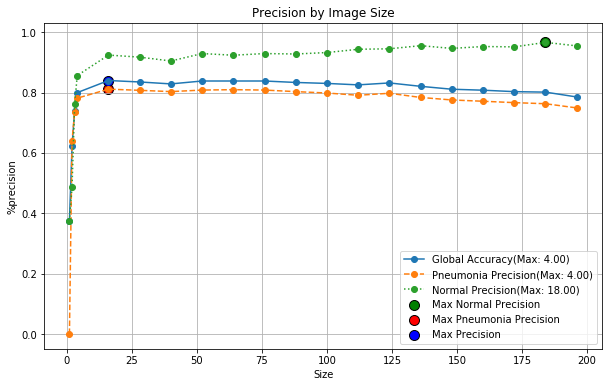

In [18]:
def show_size_plot():
    data = pd.read_csv('Metrics/size_precision.csv')
    x = data['Size'].values
    y1 = data['Accuracy'].values
    y2 = data['Pneumonia precision'].values
    y3 = data['Normal Precision'].values
    max_normal = y3.argmax()
    max_pneumonia = y2.argmax()
    max_precision = y2.argmax()
    plt.figure(figsize=(10, 6))
    plt.plot(x, y1, label=f'Global Accuracy(Max: {max_precision:.2f})', marker='o', linestyle='-')
    plt.plot(x, y2, label=f'Pneumonia Precision(Max: {max_pneumonia:.2f})', marker='o', linestyle='--')
    plt.plot(x, y3, label=f'Normal Precision(Max: {max_normal:.2f})', marker='o', linestyle=':')

    plt.scatter(x[max_normal], y3[max_normal], color='green', s=100, edgecolors='black',
                label='Max Normal Precision')
    plt.scatter(x[max_pneumonia], y2[max_pneumonia], color='red', s=100, edgecolors='black',
                label='Max Pneumonia Precision')
    plt.scatter(x[max_precision], y1[max_precision], color='blue', s=100, edgecolors='black',
                label='Max Precision')
    plt.xlabel('Size')
    plt.ylabel('%precision')
    plt.title('Precision by Image Size')
    plt.legend()
    plt.grid(True)
    plt.show()


show_size_plot()

Il est aussi possible de tester les images de validation si besoin à partir modèle pour savoir si elles sont justes ou non.

In [ ]:
@timing_function
def predict_function(image_path, model):
    print("Starting predicting model for the picture at", image_path)
    image = process_new_image(image_path)
    prediction = model.predict([image])
    print("Predicted Class:", "Pneumonia" if prediction[0] == 1 else "Normal")
    return prediction[0]

def predict_folder(folder_path, model):
    """
    Evaluates all images in a specified folder using a trained model, checks if predictions match the labels derived from file names.
    
    :param folder_path: Path to the folder containing the test images.
    :param model: Trained machine learning model.
    :return: None
    """
    correct_predictions = 0
    total_images = 0
    for filename in os.listdir(folder_path):
        image_path = os.path.join(folder_path, filename)
        print(f"Processing image: {filename}")
        image = process_new_image(image_path)
        prediction = model.predict([image])
        predicted_label = "Pneumonia" if prediction[0] == 1 else "Normal"
        print("Predicted Class:", predicted_label)
        actual_label = "Normal" if 'normal' in filename.lower() else "Pneumonia"
        if predicted_label.lower() == actual_label.lower():
            correct_predictions += 1
        else:
            print(f"Mismatch found: File {filename} predicted as {predicted_label} but is {actual_label}")
        total_images += 1
    accuracy = correct_predictions / total_images
    print(f"Accuracy: {accuracy:.2f} ({correct_predictions}/{total_images} correct)")


### Les limites du KNN
Le KNN est une méthode simple et efficace, qui fonctionne bien avec un petit nombre de données et lorsque la relation entre les attributs est assez complexe pour ne pas être bien capturée par des modèles linéaires. Cependant, il présente quelques limites à d'autres méthodes avancées :

* Scalabilité : KNN peut être très lent avec de grandes bases de données, car il doit calculer la distance entre le point cible et chaque point de données existant. Plus on prend de voisins et plus, on s'expose à un potentiel mauvais voisin. 
* Dimensionnalité : KNN voit sa performance diminue rapidement à mesure que le nombre de dimensions (caractéristiques) des données augmente. Dans notre cas où on prend des images avec des pixels et on en fait des matrices, c'est d'autant plus important. Prendre des grandes images est beaucoup plus complexe et demande beaucoup plus de performances de la part de la machine. C'est les cas de toutes les méthodes, mais lors de l'utilisation avec le knn pour l'optimisation, on passait de 48s pour 68px à 226 pour 150 ce qui équivaut au triple.
* Sensibilité au bruit : Étant donné que KNN prend des décisions de classement basées uniquement sur les voisins les plus proches, il peut être sensible au bruit dans les données d'entraînement. Une fausse donnée représente un faux-voisin. Etant donné qu'on en a un nombre limité cela peut vite fausser tous les résultats. 
* Choix des paramètres : Le choix de la métrique de distance et le nombre de voisins (k) peuvent avoir un impact significatif sur les performances du modèle, nécessitant souvent une recherche approfondie via des méthodes comme la validation croisée. C'est ce que nous avions vu dans la partie de cross-validation du modèle des KNN 
<br>

Pour ce qui est des cas bacterial et en provenance de virus le modèle était beaucoup trop imprécis et confondait les cas de virus et de bactérie. 

In [ ]:
def k_nearest_neighbors():
    knn = cross_validation()
    # Test the model
    accuracy, report = test_predict_model(knn, x_test, y_test)
    # to add to a previous file modify the w into a
    with open('Metrics/Knn_metrics.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Metric', 'Value'])
        writer.writerow(['Test Accuracy', f"{accuracy:.2f}"])
        writer.writerow([])
        writer.writerow(['Detailed report'])
        writer.writerow(['Class', 'Precision', 'Recall', 'F1-Score', 'Support'])
        for key, metrics in report.items():
            if key in ["Normal", "Pneumonia"]:
                writer.writerow([key, f"{metrics['precision']:.2f}", f"{metrics['recall']:.2f}",
                                 f"{metrics['f1-score']:.2f}", metrics['support']])
